# Example 1

## 2D Case

**Content**

This notebook reproduces the first example of the paper. It consists of four main subheadings;

- Importing the *hcpinnseikonal* package functions
- Define the arguments for the input parameters
- Setup the medium and compute the data
- Training and inference

**Saving directory**

The notebook utilized [*wandb*](https://wandb.ai) for keeping track of the parameters and experiments. You can uncomment the *wandb* call to turn this feature off. Accordingly you need to specify the folder to save your experiment by changing the related *wandb* line inside the main function below.

## Import *hcpinnseikonal* package functions

In [1]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from argparse import ArgumentParser   
from scipy import interpolate

from hcpinnseikonal.utils import *
from hcpinnseikonal.model import *
from hcpinnseikonal.train import *
from hcpinnseikonal.plot import *
from hcpinnseikonal.arguments import *

args = parser.parse_args([])

args.use_wandb='n'

dict_args = vars(args)
print(dict_args)

# Change these lines for the wandb setup
if args.use_wandb=='y':
    wandb.init(project=args.project_name)
    wandb.run.log_code(".")
    wandb_dir = wandb.run.dir
else:
    args.save_folder='../saves/saves_fullnss2d'
    from pathlib import Path
    Path(args.save_folder).mkdir(parents=True, exist_ok=True)
    wandb_dir = args.save_folder

{'lateral_spacing': 0.01, 'vertical_spacing': 0.01, 'max_offset': 5.0, 'max_depth': 1.0, 'rec_spacing': 10, 'sou_spacing': 10, 'num_epochs': 250, 'num_neurons': 20, 'num_layers': 10, 'learning_rate': 0.001, 'model_type': 'seam', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'n', 'earth_scale': 'n', 'scale_factor': 10, 'reduce_after': 15, 'seed': 123, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 3.0, 'initial_velocity': 4, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 3, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'n', 'xid_well': 5, 'last_vmultiplier': 5, 'nu_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 1.0, 'event_factor': 1.0, 'checker_size': 5.0, 'tau_act': 'None', 'empty_middle': 'n', 'factoriz

## Define arguments

In [2]:
args.scale_factor=2 
args.until_cmb='y' 
args.num_epochs=500
args.seed=1234 
args.learning_rate=1e-3 
args.rescale_plot='y' 
args.initial_velocity=3 
args.zid_source=5 
args.zid_receiver=0 
args.data_type='full' 
args.irregular_grid='y' 
args.num_layers=12 
args.model_type='marmousi' 
args.v_multiplier=3 
args.factorization_type='additive' 
args.tau_act='tanh' 
args.tau_multiplier=1 
args.max_offset=8.6 
args.max_depth=1 
args.vertical_spacing=0.01 
args.lateral_spacing=0.03 
args.num_neurons=24 
args.causality_factor=.5 

args.causality_weight='type_0' 
args.reduce_after=50 
args.field_synthetic='n' 
args.event_factor=0.9 
args.station_factor=0.1 
args.residual_network='y' 
args.empty_middle='n' 
args.regular_station='y' 
args.rec_spacing=20 
args.sou_spacing=40

dict_args = vars(args)
print(dict_args)

{'lateral_spacing': 0.03, 'vertical_spacing': 0.01, 'max_offset': 8.6, 'max_depth': 1, 'rec_spacing': 20, 'sou_spacing': 40, 'num_epochs': 500, 'num_neurons': 24, 'num_layers': 12, 'learning_rate': 0.001, 'model_type': 'marmousi', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'y', 'earth_scale': 'n', 'scale_factor': 2, 'reduce_after': 50, 'seed': 1234, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'y', 'depth_shift': 'n', 'tau_multiplier': 1, 'initial_velocity': 3, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 3, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'y', 'xid_well': 5, 'last_vmultiplier': 5, 'nu_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 0.1, 'event_factor': 0.9, 'checker_size': 5.0, 'tau_act': 'tanh', 'empty_middle': 'n', 'factoriz

## Medium setup and data interpolation

Cuda installed! Running on GPU!
Device: cuda:0 Tesla V100-SXM2-32GB
4.486768969918806 15 15 8 8
Loading time: 0.15 minutes


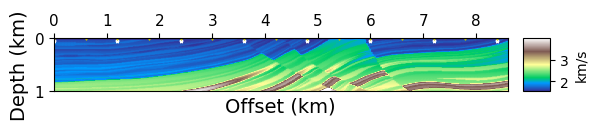

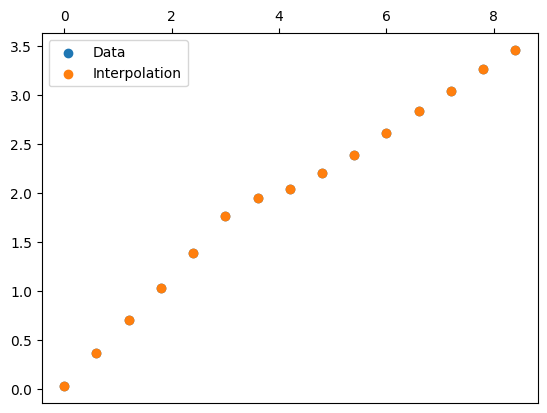

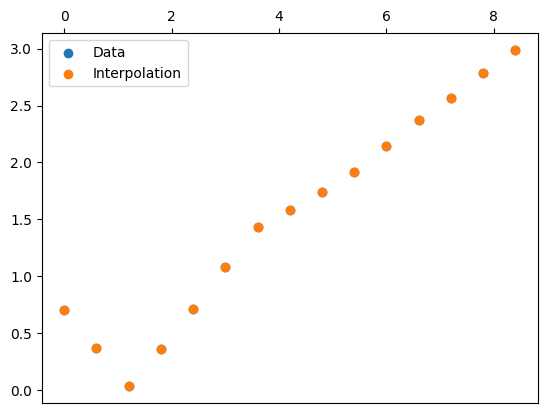

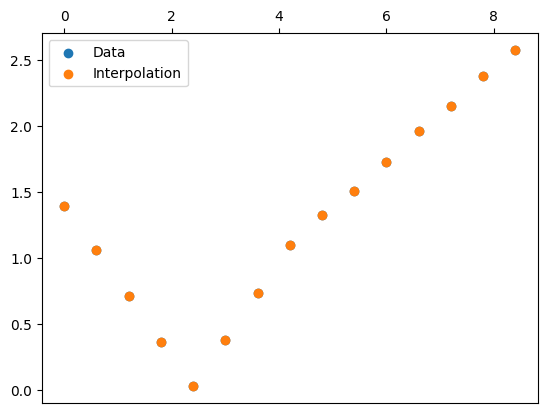

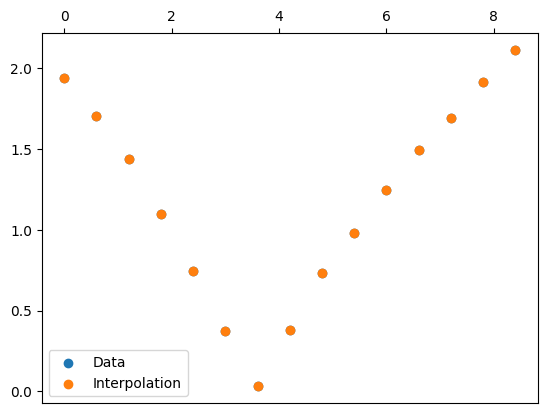

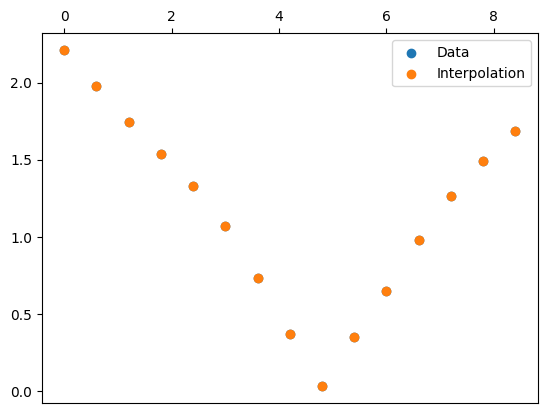

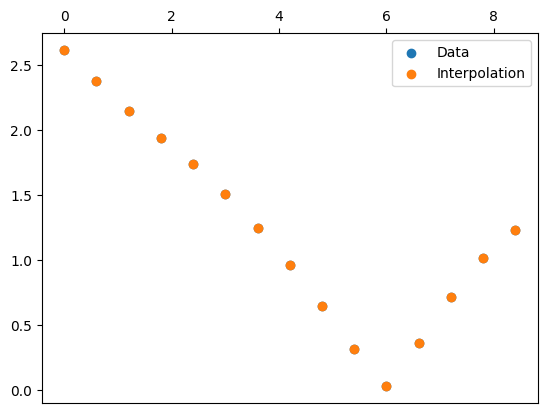

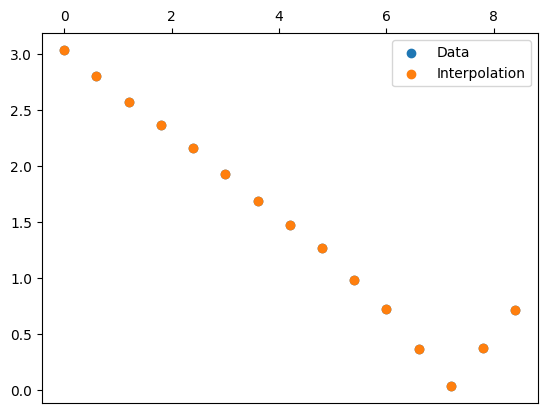

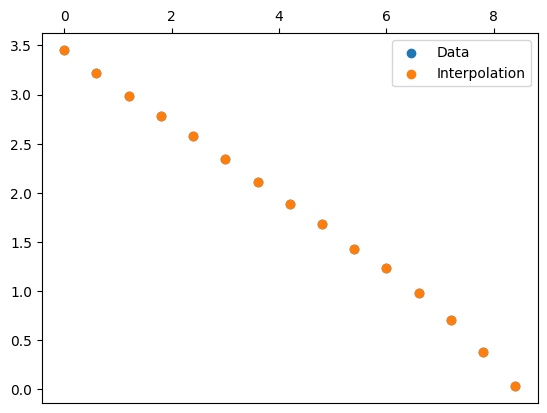

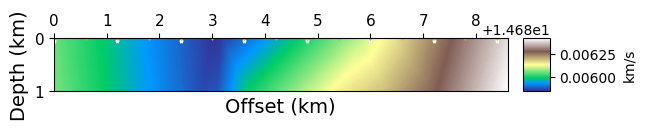

In [3]:
# Setup
if args.use_wandb=='y':
    wandb.config.update(args)

seed = args.seed

set_seed(seed)
device = set_device()

# Medium
data_type = args.data_type
deltar = args.rec_spacing
deltas = args.sou_spacing

# Computational model parameters
zmin = -0.1 if args.field_synthetic=='y' else 0; zmax = args.max_depth; deltaz = args.vertical_spacing;
xmin = 0.; xmax = args.max_offset; deltax = args.lateral_spacing;

if args.earth_scale=='y':
    earth_radi = 6371/args.scale_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax
    zmin, zmax, deltaz = earth_radi*zmin, earth_radi*zmax, earth_radi*deltaz

# Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)
z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

# Number of training points
num_tr_pts = 4000 #int(args.num_points * nz * nx)

if args.field_synthetic=='y':
    import pandas as pd
    import pygmt
    import numpy as np

    import pandas as pd

    # Earthquake events location
    location = pd.read_csv('/home/taufikmh/KAUST/fall_2022/GFATT_PINNs/data/fang_etal_2020/sjfzcatlog.csv')

    # Recorded traveltime data
    traveltime = pd.read_table('/home/taufikmh/KAUST/fall_2022/GFATT_PINNs/data/fang_etal_2020/sjfz_traveltime.dat', delim_whitespace='y')

    # Rounding to make the coordinates rounding the same
    location, traveltime = location.round(3), traveltime.round(3)

    # Merge
    data = pd.merge(traveltime, location,  how='left', left_on=['evlat','evlon','evdep'], right_on = ['evlat','evlon','evdep'])

    # Create earthquake group
    data['event_id'] = data.groupby(['evlat', 'evlon', 'evdep']).cumcount() + 1
    data['station_id'] = data.groupby(['stlat', 'stlon', 'stele']).cumcount() + 1

    # Station only
    sta_only = data.drop_duplicates(subset=['stlat', 'stlon'], keep='last')

    # Event only
    eve_only = data.drop_duplicates(subset=['evlat', 'evlon'], keep='last')

    region = [-118, -115, 32.5, 34.50]
    x0,x1,y0,y1 = -117.45, -115.55, 34.15, 32.76

    # eve_only['dist_to_line'] = 
    p1=np.array([(360+x0)*np.ones_like(eve_only.event_id.values), y0*np.ones_like(eve_only.event_id.values)])
    p2=np.array([(360+x1)*np.ones_like(eve_only.event_id.values), y1*np.ones_like(eve_only.event_id.values)])
    p3=np.array([eve_only.evlon, eve_only.evlat])

    d = pd.DataFrame(np.cross((p2-p1).T,(p3-p1).T)/np.linalg.norm((p2-p1).T))
    eve_only.loc[:, 'closest_event'] = np.copy(d[0].values)

    # sta_only['dist_to_line'] = 
    p1=np.array([(360+x0)*np.ones_like(sta_only.station_id.values), y0*np.ones_like(sta_only.station_id.values)])
    p2=np.array([(360+x1)*np.ones_like(sta_only.station_id.values), y1*np.ones_like(sta_only.station_id.values)])
    p3=np.array([sta_only.stlon, sta_only.stlat])

    d = pd.DataFrame(np.cross((p2-p1).T,(p3-p1).T)/np.linalg.norm((p2-p1).T))
    sta_only.loc[:, 'closest_station'] = np.copy(d[0].values)

    closest_sta = sta_only[np.abs(sta_only['closest_station'])<0.003]
    closest_eve = eve_only[np.abs(eve_only['closest_event'])<0.00003]

    grid = pygmt.datasets.load_earth_relief(resolution="03m", region=region)

    points = pd.DataFrame(
        data=np.linspace(start=(x0, y0), stop=(x1, y1), num=len(x)),
        columns=["x", "y"],
    )

    track = pygmt.grdtrack(points=points, grid=grid, newcolname="elevation")
    xtop = track.x.values + 360
    ztop = track.elevation.values*1e-3

    xsta = closest_sta.stlon.values
    zsta = closest_sta.stele.values

    xeve = closest_eve.evlon.values
    zeve = closest_eve.evdep.values

    xtop,xsta,xeve = xtop-xtop.min(),xsta-xsta.min(),xeve-xeve.min()
    xtop,xsta,xeve = xtop/xtop.max()*xmax,xsta/xsta.max()*xmax,xeve/xeve.max()*xmax

    ztop,zsta,zeve = ztop-ztop.min(),zsta-zsta.min(),zeve-zeve.min()
    ztop,zsta,zeve = args.station_factor*ztop/ztop.max()+zmin,args.station_factor*zsta/zsta.max()+zmin,zmax-args.event_factor*zeve/zeve.max()

    xsta,xeve,zsta,zeve = xsta[(xsta>xtop.min()) & (xsta<xtop.max())],xeve[(xeve>xtop.min()) & (xeve<xtop.max())],zsta[(xsta>xtop.min()) & (xsta<xtop.max())],zeve[(xeve>xtop.min()) & (xeve<xtop.max())]

    if args.exclude_topo=='y':
        ztop, zsta = zmin*np.ones_like(ztop), zmin*np.ones_like(zsta)

    ztop, zsta = zmin-ztop, zmin-zsta

    id_sou_z = np.array([]).astype(int)

    for szi in zeve.round(2):
        sid = np.where(np.abs(z.round(3)-szi)<1e-6)
        id_sou_z = np.append(id_sou_z,sid)

    id_rec_z = np.array([]).astype(int)

    for rzi in zsta.round(2):
        sid = np.where(np.abs(z.round(3)-rzi)<1e-6)
        id_rec_z = np.append(id_rec_z,sid)

    id_sou_x = np.array([]).astype(int)

    for sxi in xeve.round(2):
        sid = np.where(np.abs(x.round(3)-sxi)<1.5e-2)
        id_sou_x = np.append(id_sou_x,sid)

    id_rec_x = np.array([]).astype(int)

    for rxi in xsta.round(2):
        sid = np.where(np.abs(x.round(3)-rxi)<1.5e-2)
        id_rec_x = np.append(id_rec_x,sid)

    id_top_x = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    if args.regular_station=='y':
        id_rec_x = id_top_x[::args.rec_spacing]
        id_rec_z = id_top_z[::args.rec_spacing]

    if args.append_shot=='y':
        for i in range(8):
            id_sou_x = np.append(id_sou_x, len(x)-1-2*i)
            id_sou_z = np.append(id_sou_z, len(z)-1-int(0.5*i))
            
    plt.plot(args.plotting_factor*(xtop-xtop.min()), args.plotting_factor*ztop)
    plt.scatter(args.plotting_factor*(xeve-xtop.min()), args.plotting_factor*zeve)
    plt.scatter(x[id_rec_x], z[id_rec_z], c='y', marker='v')
    plt.title('Cross-section')
    plt.xlabel('X (km)')
    plt.ylabel('Z (km)')
    plt.gca().invert_yaxis()
    plt.axis('tight')
    plt.savefig(os.path.join(wandb_dir, 'cross_section.png'), format='png', bbox_inches="tight")
else:
    zeve, xeve = z[args.zid_source]*np.ones_like(x[::deltas]), x[::deltas]
    zsta, xsta = z[args.zid_receiver]*np.ones_like(x[::deltar]), x[::deltar]
    ztop, xtop = zmin*np.ones_like(x), np.copy(x)

    id_sou_z = np.array([]).astype(int)

    for szi in zeve.round(2):
        sid = np.where(np.abs(z.round(3)-szi)<1e-6)
        id_sou_z = np.append(id_sou_z,sid)

    id_sou_x = np.array([]).astype(int)

    for sxi in xeve.round(2):
        sid = np.where(np.abs(x.round(3)-sxi)<1e-6)
        id_sou_x = np.append(id_sou_x,sid)

    id_rec_z = np.array([]).astype(int)

    for szi in zsta.round(2):
        sid = np.where(np.abs(z.round(3)-szi)<1e-6)
        id_rec_z = np.append(id_rec_z,sid)

    id_rec_x = np.array([]).astype(int)

    for sxi in xsta.round(2):
        sid = np.where(np.abs(x.round(3)-sxi)<1e-6)
        id_rec_x = np.append(id_rec_x,sid)

# Keeping the number of shots fixed while centering the shots location
if args.middle_shot=='y':
    id_sou_left = x.shape[0]//2-len(id_sou_x)//2
    id_sou_x = np.array(range(id_sou_left, id_sou_left+len(id_sou_x)))

if args.explode_reflector=='y':
    id_sou_x = np.arange(0, len(x), args.sou_spacing)
    id_sou_z = np.ones_like(id_sou_x)*(len(z)-1)

if args.empty_middle=='y':
    id_sou, id_rec = (np.array(id_sou_x)<=(len(x)//2-50))|(np.array(id_sou_x)>=(len(x)//2+50)), (np.array(id_rec_x)<=(len(x)//2-50))|(np.array(id_rec_x)>=(len(x)//2+50))
    if args.field_synthetic=='n':
        id_sou_x = np.array(id_sou_x)[id_sou]
        id_sou_z = np.array(id_sou_z)[id_sou]
    id_rec_x = np.array(id_rec_x)[id_rec]
    id_rec_z = np.array(id_rec_z)[id_rec]

sz = z[id_sou_z]
sx = x[id_sou_x]

Z,X,SX = np.meshgrid(z,x,sx,indexing='ij')

SZ = np.ones(SX.shape)*sz # Creating an array of sources along z with same size as SX


vel = np.fromfile('../data/marmousi.bin', np.float32).reshape(221, 601)
x1 = np.linspace(0, 5, 601)
z1 = np.linspace(0, 1, 221) 
x2 = np.linspace(0.25, 5, len(x))
z2 = np.linspace(0.09, 0.55, len(z)) 
f = interpolate.interp2d(x1, z1, vel, kind='cubic')
vel = f(x2, z2)

# Extending the velocity model in thirs dimension byy repeatin the array
velmodel = np.repeat(vel[...,np.newaxis],sx.size,axis=2)

print(np.nanmax(velmodel), len(id_rec_z), len(id_rec_x), len(id_sou_z), len(id_sou_x))
plot_section(velmodel[:,:,0], 'v_true.png', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])

if args.depth_shift=='y':
    zmin, zmax, z, sz, Z, SZ = zmin+5, zmax+5, z+5, sz+5, Z+5, SZ+5

X_star = [Z.reshape(-1,1), X.reshape(-1,1), SX.reshape(-1,1)] # Grid points for prediction 

# Numerical traveltime
T_data = numerical_traveltime(vel, len(x), len(z), len(id_sou_x), xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z)

# Plots
if args.model_type=='checkerboard':
    plot_section((6 + 6.5217391304347826*Z[:,:,0])/args.scale_factor, "v_back.png", 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])
    plot_section(velpert[:,:,0]/args.scale_factor, "v_pert.png", 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])

# Interpolation

Td_nn = np.zeros_like(T_data)
taudx_nn = np.zeros_like(T_data)

Ti_data = np.zeros((len(x[id_rec_x])*len(id_sou_x)))
xri = np.tile(x[id_rec_x], len(id_sou_x))
zri = np.tile(z[id_rec_z], len(id_sou_z))
xsi = np.repeat(x[id_sou_x], len(id_rec_x))
zsi = np.repeat(z[id_sou_z], len(id_rec_z))

for i in range(len(id_sou_x)):
    Ti_data[i*len(x[id_rec_x]):(i+1)*len(x[id_rec_x])] = T_data[id_rec_z,id_rec_x,i]

rand_idx = np.random.permutation(np.arange(len(Ti_data)))

X_ori = np.vstack((xri, zri, xsi, zsi)).T
y_ori = Ti_data

X_all = X_ori[rand_idx,:]
y_all = y_ori[rand_idx]

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

X_ori = torch.from_numpy(X_ori).float()

all_dataset = torch.utils.data.TensorDataset(X_all, y_all)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16, shuffle=True)

if data_type=='nn':
    torch.manual_seed(8888)
    model = FullyConnectedNetwork(4, 1, n_hidden=[args.data_neurons]*args.data_layers, act='elu')
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # best
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(5*args.reduce_after), verbose=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(4*args.reduce_after), verbose=True)
    criterion = torch.nn.MSELoss()
    model.train()
    loss_data = []
    for epoch in range(int(5e3)):
        total_loss = 0.
        model.train()
        loss = 0
        for x_i, y_i in all_loader:
            optimizer.zero_grad()
            yest = model(x_i).view(-1)
            loss = criterion(yest, y_i)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 and epoch > 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X_all[:,0].detach().numpy().size}')
        mean_loss = total_loss / X_all[:,0].detach().numpy().size
        # wandb.log({"data_loss": mean_loss})
        scheduler.step(mean_loss)
        loss_data.append(mean_loss)

    Td_nn = np.zeros_like(T_data)
    
    if args.field_synthetic=='y':
        X_all = [np.tile(x[id_top_x], len(sx)), np.tile(z[id_top_z], len(sz)), 
                 np.repeat(x[id_sou_x], len(x[id_top_x])), 
                 np.repeat(z[id_sou_z], len(z[id_top_z]))]
    else:
        X_all = [np.tile(x, len(sx)), np.tile(z[args.zid_receiver]*np.ones_like(x), len(sz)), 
                 np.repeat(x[id_sou_x], len(x)), 
                 np.repeat(z[id_sou_z], len(x))]

    model.eval()
    Td_pred = model(torch.FloatTensor(X_all).T)

    for i in range(len(id_sou_x)):
        Td_nn[:,:,i] = Td_pred[i*len(x):(i+1)*len(x)].detach().numpy().reshape(-1)

    # Convergence history plot for verification
    fig = plt.figure()
    ax = plt.axes()
    ax.semilogy(loss_data)

    ax.set_xlabel('Epochs',fontsize=14)

    plt.xticks(fontsize=11)

    ax.set_ylabel('Loss',fontsize=14)
    plt.yticks(fontsize=11);
    plt.grid()
    plt.savefig(os.path.join(wandb_dir, "data_loss.png"), format='png', bbox_inches="tight")

    # Save model
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_data
    }, wandb_dir+'/saved_data_model')

# Analytical solution for the known traveltime part
if args.depth_shift=='y':
    vs = args.initial_velocity #velmodel[np.round((SZ-5)/deltaz).astype(int),np.round(SX/deltax).astype(int),0]
else:
    vs = velmodel[np.round(SZ/deltaz).astype(int),np.round(SX/deltax).astype(int),0]

T0 = np.sqrt((Z-SZ)**2 + (X-SX)**2)/vs;
px0 = np.divide(X-SX, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-SZ, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

if args.field_synthetic=='y':
    xf = np.arange(xmin,xmax+0.1*deltax,0.1*deltax)
    zf = np.arange(zmin,zmax+0.1*deltaz,0.1*deltaz)
    T_topo = np.zeros((len(zf), len(xf), len(id_sou_x)))
    for i in range(len(id_sou_x)):
        f = interpolate.interp2d(x, z, T_data[:,:,i], kind='cubic')
        T_topo[:,:,i] = f(xf, zf)
    id_top_x = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    taud_topo = np.divide(T_data, T0, where=T0!=0)[id_top_z, id_top_x, :]
    T_topo = T_data[id_top_z, id_top_x, :]

    taud_topo = np.repeat(taud_topo, nz).reshape(nx,len(id_sou_x),nz).swapaxes(1,2).swapaxes(0,1)
    T_topo = np.repeat(T_topo, nz).reshape(nx,len(id_sou_x),nz).swapaxes(1,2).swapaxes(0,1)

Td_hc = np.zeros_like(T0)
T0_hc = np.zeros_like(T0)
taud_hc = np.zeros_like(T0)
taudx_hc = np.zeros_like(T0)

for i in range(len(id_sou_x)):
    T0_hc[:,:,i] = np.tile(T0[0,:,i], nz).reshape(nz,nx)

    # Numerical
    if data_type=='full':
        Td_hc[:,:,i] = np.tile(T_data[0,:,i], nz).reshape(nz,nx)

    # NN-based interpolation
    elif data_type=='nn':
        Td_hc[:,:,i] = Td_nn[:,:,i].reshape(nz,nx)

    if args.factorization_type=='multiplicative':   
        taud_hc[:,:,i] = np.divide(Td_hc[:,:,i], T0_hc[:,:,i], out=np.ones_like(T0_hc[:,:,i]),
                                   where=T0_hc[:,:,i]!=0)
    else:
        taud_hc[:,:,i] = Td_hc[:,:,i] - T0_hc[:,:,i]

    # Numerical
    if data_type=='full':
        taudx_hc[:,:,i] = np.gradient(taud_hc.reshape(nz,nx,len(id_sou_x))[:,:,i], deltax, axis=1)

    # NN-based interpolation
    elif data_type=='nn':
        taudx_hc[:,:,i] = np.gradient(taud_hc.reshape(nz,nx,len(id_sou_x))[:,:,i], deltax, axis=1)

if args.field_synthetic=='y':

    NAN = np.ones_like(X)
    for i in range(z.shape[0]):
        for j in range(x.shape[0]):
            if z[i] < Z[id_top_z, id_top_x, 0][j]:
                NAN[i,j,:] = float("Nan")
                
# Interpolation check            
plot_int = len(id_sou_x)//5 if len(id_sou_x)>=5 else 1
for i in range(0, len(id_sou_x), plot_int):
    plt.figure()
    plt.scatter(x[id_rec_x], T_data[id_rec_z,id_rec_x,i], label='Data')
    plt.scatter(x[id_rec_x], Td_hc[id_rec_z,id_rec_x,i], label='Interpolated')
    plt.legend(['Data', 'Interpolation'])
    plt.savefig(os.path.join(wandb_dir, "interpolation.png"), format='png', bbox_inches="tight")

# locate source boolean
import time
start_time = time.time()

TOLX = 1e-9
TOLZ = 1e-9

sids = np.array([]).astype(int)

for i in range(len(sx)):
    sid = np.where(((np.abs(Z.ravel()-sz[i])<TOLZ) & (np.abs(X.ravel()-sx[i])<TOLX) & (np.abs(SZ.ravel()-sz[i])<TOLZ) & (np.abs(SX.ravel()-sx[i])<TOLX))==True)[0]
    sids = np.append(sids,sid)    

# locate source boolean
isource = np.ones_like(X_star[0]).reshape(-1,).astype(bool)
isource[sids] = False

velmodel = velmodel.reshape(-1,1)
px0 = px0.reshape(-1,1)
pz0 = pz0.reshape(-1,1)
T0 = T0.reshape(-1,1)
T_data = T_data.reshape(-1,1)

taud = taud_hc.reshape(-1,1)
if args.factorization_type=='multiplicative':
    taud[~isource] = 1.    
taudx = taudx_hc.reshape(-1,1)
index = torch.arange(T0.size)

perm_id = np.random.permutation(X.size-sx.size)

input_wsrc = [X, Z, SX, taud, taudx, T0, px0, pz0, index]
input_wosrc = [i.ravel()[isource.reshape(-1)][perm_id] for i in input_wsrc]
if args.field_synthetic=='y':
    input_wonan = [i.ravel()[~np.isnan(NAN.ravel()[isource.reshape(-1)][perm_id])] for i in input_wosrc]

# Network
lay = 'linear'
ini = args.initialization
bias = 2
mean = 0.5
std = 1
opttype = 'adam'
lr = args.learning_rate

torch.manual_seed(seed)
if args.residual_network=='n':
    tau_model = FullyConnectedNetwork(3, 1, [args.num_neurons]*args.num_layers, last_act=args.tau_act, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
else:
    tau_model = ResidualNetwork(3, 1, num_neurons=args.num_neurons, num_layers=args.num_layers, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
tau_model.to(device)

torch.manual_seed(seed)
if args.residual_network=='n':
    v_model = FullyConnectedNetwork(2, 1, [args.num_neurons//2]*args.num_layers, act=args.activation, lay=lay, last_act='relu', last_multiplier=args.v_multiplier)
else:
    v_model = ResidualNetwork(2, 1, num_neurons=args.num_neurons//2, act='relu', last_act='relu', num_layers=args.num_layers, lay=lay, last_multiplier=args.v_multiplier)
v_model.to(device)
v_model.apply(lambda m: init_weights(m, init_type=ini, bias=bias, mean=mean, std=std))

perc = args.num_points

if args.irregular_grid=='y':
    npoints = int(X.size * perc)
    ipermute = np.random.permutation(np.arange(X.size))[:npoints]
else:
    ipermute = None

# Compute traveltime with randomly initialized network
pde_loader, ic = create_dataloader([i.ravel() for i in input_wsrc], sx, np.ones_like(sx)*sz.reshape(-1,),
                                   shuffle=False, fast_loader=True, perm_id=ipermute)

if args.exp_function=='y':
    rec_op = (1-np.exp((Z.reshape(nz,nx,len(id_sou_x))-z[args.zid_receiver])**args.exp_factor))
else:
    rec_op = Z.reshape(nz,nx,len(id_sou_x))


if args.factorization_type=='multiplicative':
    tau_true = np.divide(
        T_data.reshape(nz,nx,len(id_sou_x)), 
        T0.reshape(nz,nx,len(id_sou_x)), 
        out=np.ones_like(T0.reshape(nz,nx,len(id_sou_x))), 
        where=T0.reshape(nz,nx,len(id_sou_x))!=0
    )
    tau_true = tau_true - taud.reshape(nz,nx,len(id_sou_x))
    tau_true = np.divide(
        tau_true, 
        rec_op, 
        out=np.ones_like(Z.reshape(nz,nx,len(id_sou_x))), 
        where=Z.reshape(nz,nx,len(id_sou_x))!=0
    )
    T_true = (rec_op*tau_true + taud.reshape(nz,nx,len(id_sou_x)))*T0.reshape(nz,nx,len(id_sou_x))
else:
    tau_true = T_data.reshape(nz,nx,len(id_sou_x)) - T0.reshape(nz,nx,len(id_sou_x)) - taud.reshape(nz,nx,len(id_sou_x))
    tau_true = np.divide(
        tau_true, 
        rec_op, 
        out=np.ones_like(Z.reshape(nz,nx,len(id_sou_x))), 
        where=Z.reshape(nz,nx,len(id_sou_x))!=0
    )
    T_true = rec_op*tau_true + taud.reshape(nz,nx,len(id_sou_x)) + T0.reshape(nz,nx,len(id_sou_x))


v_init = evaluate_velocity(v_model, pde_loader)
tau_init = evaluate_tau(tau_model, pde_loader)

elapsed = time.time() - start_time
print('Loading time: %.2f minutes' %(elapsed/60.))

# Optimizer
if opttype == 'adam':
    optimizer = torch.optim.Adam(list(tau_model.parameters()) + list(v_model.parameters()), lr=lr, betas=(0.9, 0.999), eps=1e-5)
elif opttype == 'lbfgs':
    optimizer = torch.optim.LBFGS(list(tau_model.parameters()) + list(v_model.parameters()), line_search_fn="strong_wolfe")

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=args.reduce_after, verbose=True)

plot_section(torch_to_numpy(v_init, nx, nz, len(id_sou_x))[:,:,0], "v_init.png", 
             save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])

if data_type!='full':
    if args.field_synthetic=='y':
        for i in range(0, len(id_sou_x), plot_int):
            plot_horizontal(T_data.reshape(X.shape)[id_top_z,id_top_x,i], Td_nn[id_top_z,id_top_x,i], 
                            x*args.plotting_factor,'Interpolation Comparison','T (s)',
                            'T_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)
            plot_horizontal(smooth(np.gradient(T_data.reshape(X.shape)[id_top_z,id_top_x,i]),2,'blackman'), 
                            np.gradient(Td_nn[id_top_z,id_top_x,i]), 
                            x*args.plotting_factor,'Interpolation Comparison','dT/dx (s/km)',
                            'Tdx_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)
    else:
        for i in range(0, len(id_sou_x), plot_int):
            plot_horizontal(T_data.reshape(X.shape)[0,:,i], Td_nn[0,:,i], 
                            x*args.plotting_factor,'Interpolation Comparison','T (s)',
                            'T_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)
            plot_horizontal(smooth(np.gradient(T_data.reshape(X.shape)[0,:,i]),2,'blackman'), np.gradient(Td_nn[0,:,i]), 
                            x*args.plotting_factor,'Interpolation Comparison','dT/dx (s/km)',
                            'Tdx_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)

## Training and Inference

Epoch 0, Loss 0.0109924
Epoch 3, Loss 0.0033350
Epoch 6, Loss 0.0025635
Epoch 9, Loss 0.0025201
Epoch 12, Loss 0.0018594
Epoch 15, Loss 0.0016039
Epoch 18, Loss 0.0013889
Epoch 21, Loss 0.0009941
Epoch 24, Loss 0.0008576
Epoch 27, Loss 0.0006772
Epoch 30, Loss 0.0006262
Epoch 33, Loss 0.0006070
Epoch 36, Loss 0.0005699
Epoch 39, Loss 0.0005712
Epoch 42, Loss 0.0005509
Epoch 45, Loss 0.0004303
Epoch 48, Loss 0.0004463
Epoch 51, Loss 0.0003367
Epoch 54, Loss 0.0003322
Epoch 57, Loss 0.0004044
Epoch 60, Loss 0.0003812
Epoch 63, Loss 0.0003629
Epoch 66, Loss 0.0003769
Epoch 69, Loss 0.0003477
Epoch 72, Loss 0.0002909
Epoch 75, Loss 0.0002955
Epoch 78, Loss 0.0003594
Epoch 81, Loss 0.0003086
Epoch 84, Loss 0.0003798
Epoch 87, Loss 0.0002597
Epoch 90, Loss 0.0002921
Epoch 93, Loss 0.0003059
Epoch 96, Loss 0.0002995
Epoch 99, Loss 0.0003706
Epoch 102, Loss 0.0008240
Epoch 105, Loss 0.0003369
Epoch 108, Loss 0.0002625
Epoch 111, Loss 0.0002976
Epoch 114, Loss 0.0003291
Epoch 117, Loss 0.000234

/home/taufikmh/KAUST/fall_2022/external_repos/HCPINNsEikonal3D/src/hcpinnseikonal/plot.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


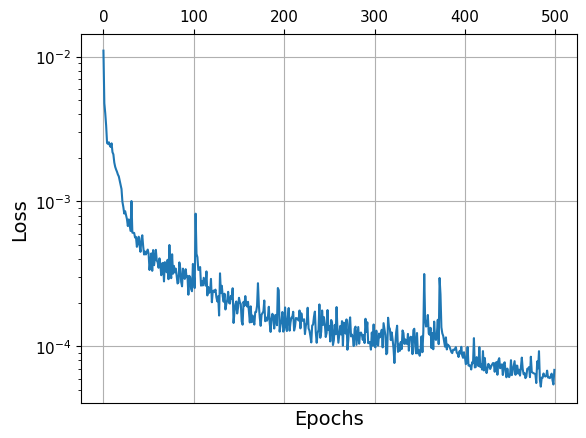

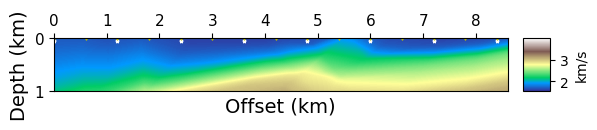

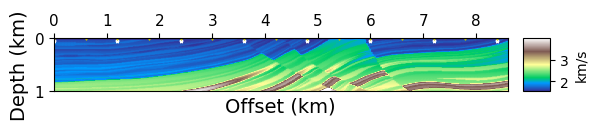

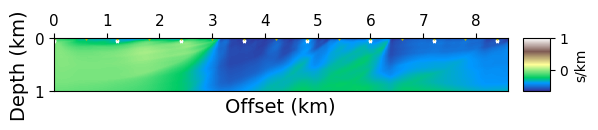

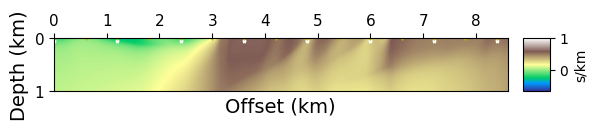

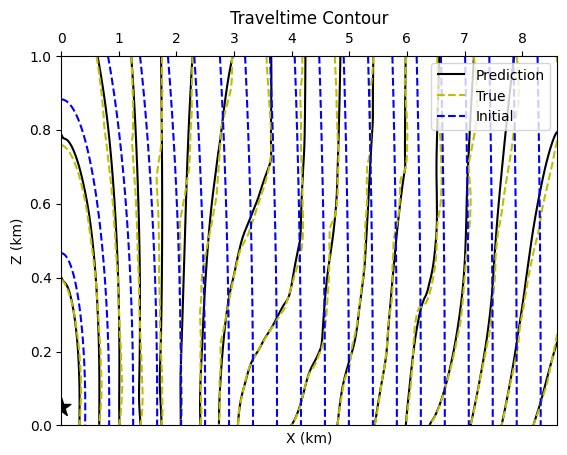

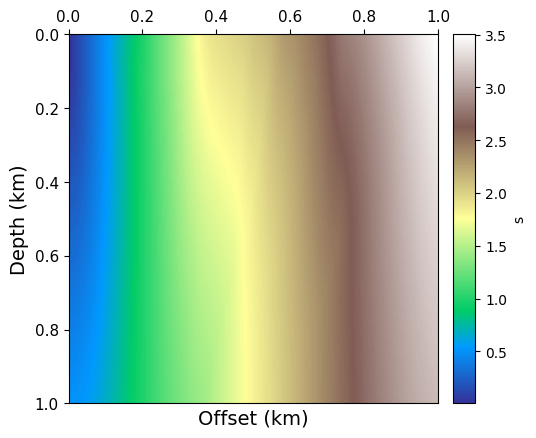

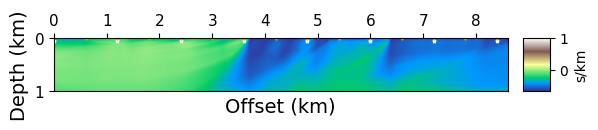

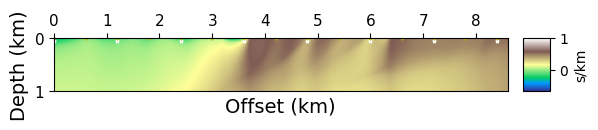

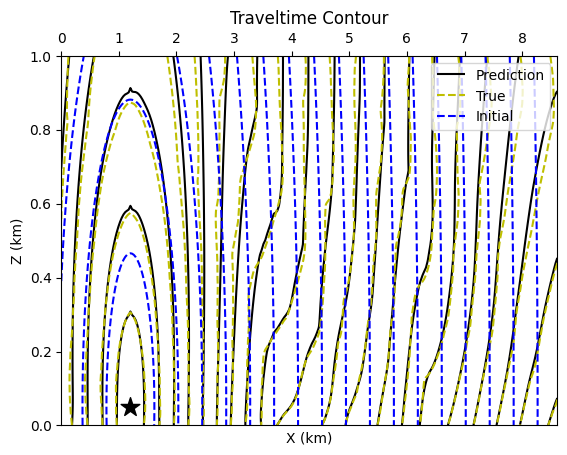

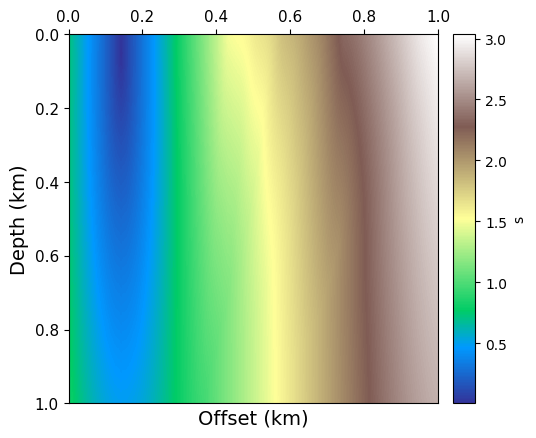

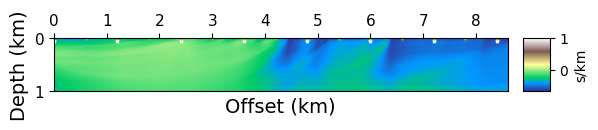

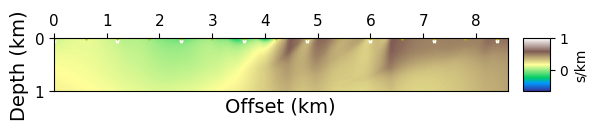

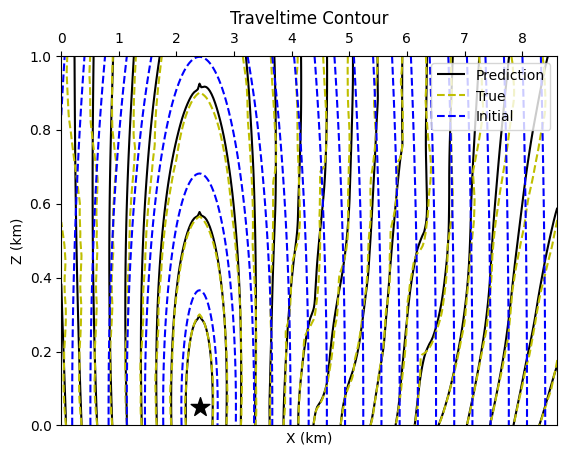

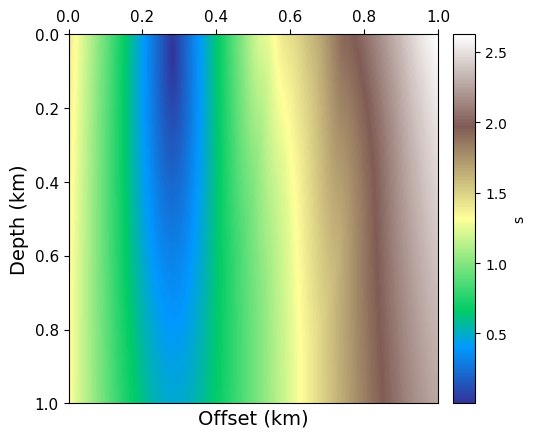

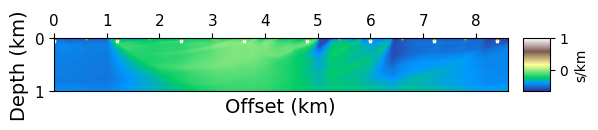

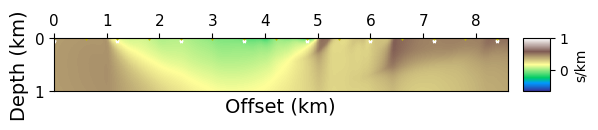

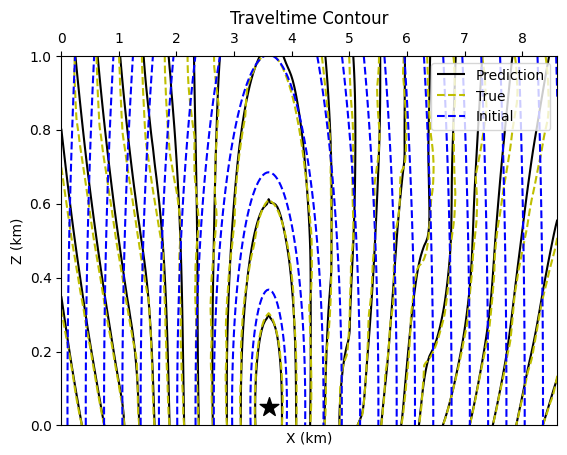

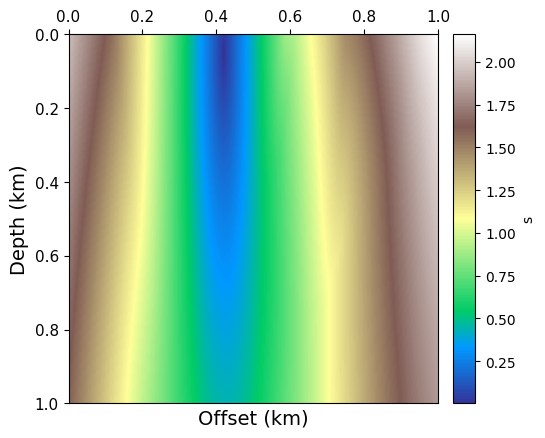

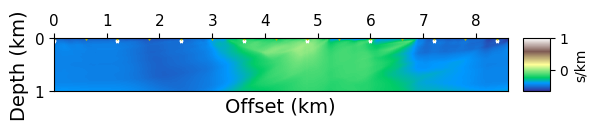

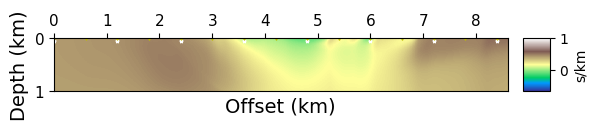

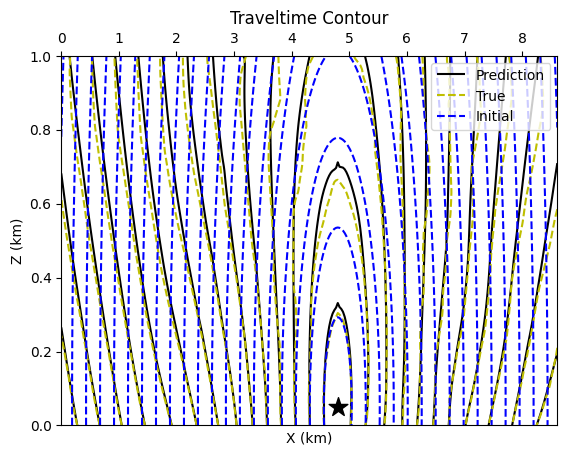

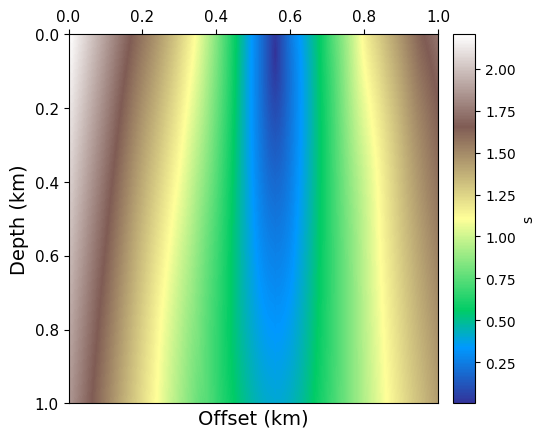

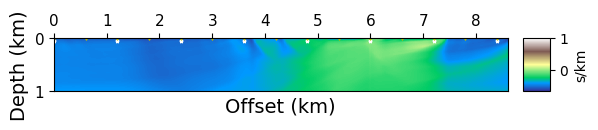

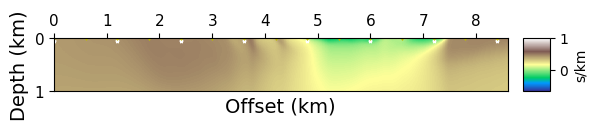

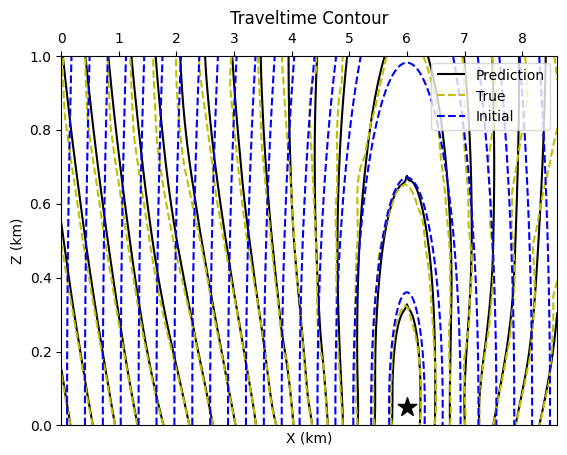

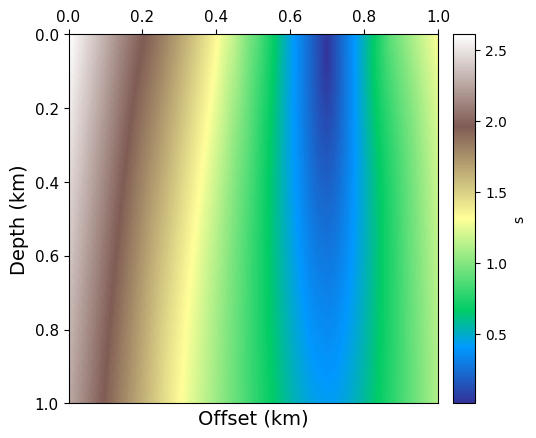

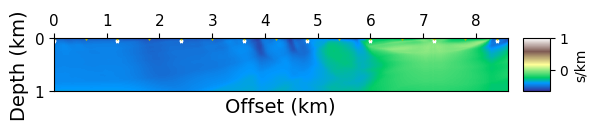

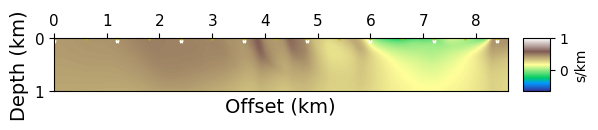

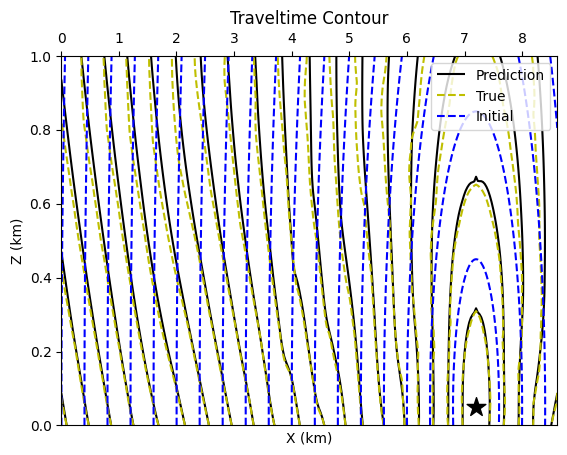

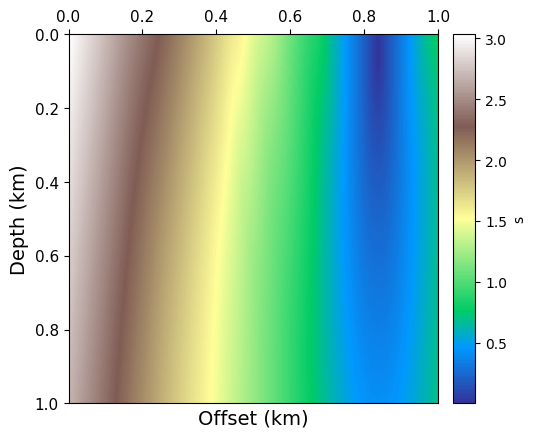

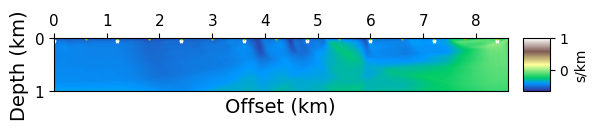

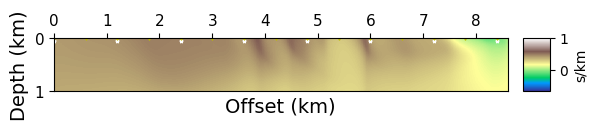

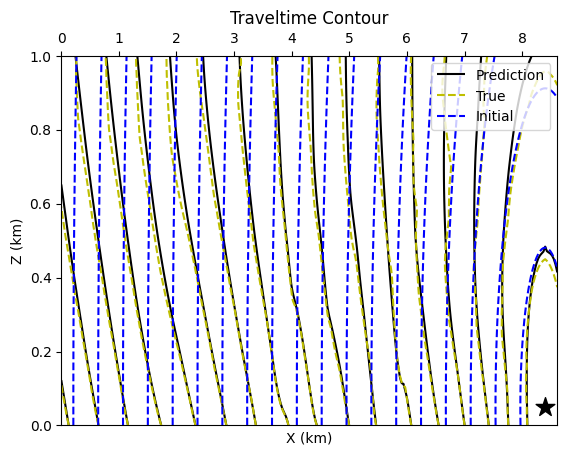

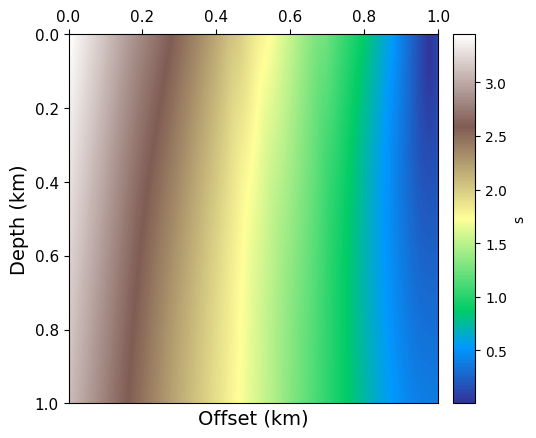

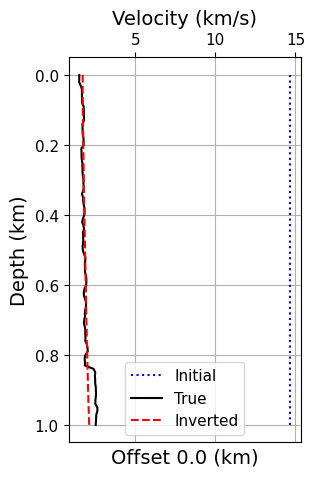

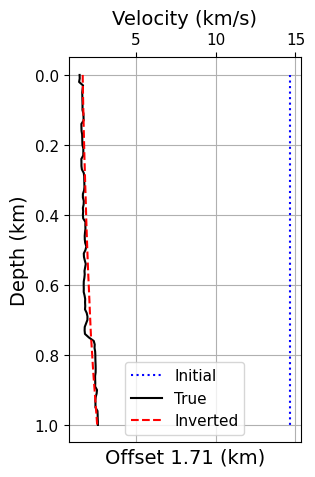

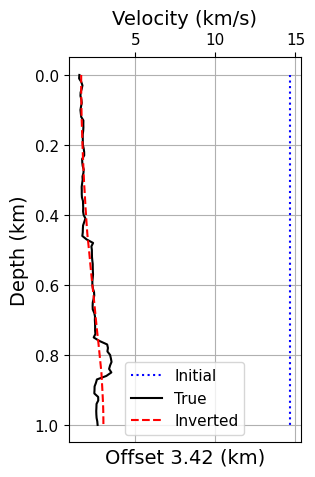

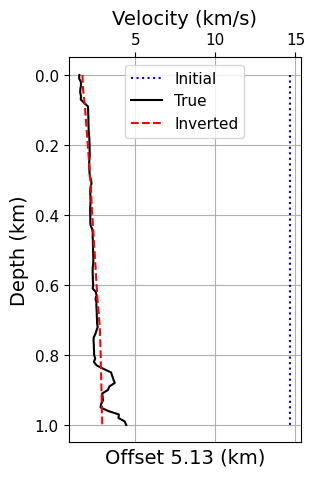

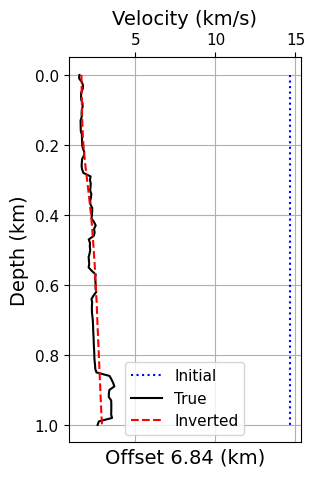

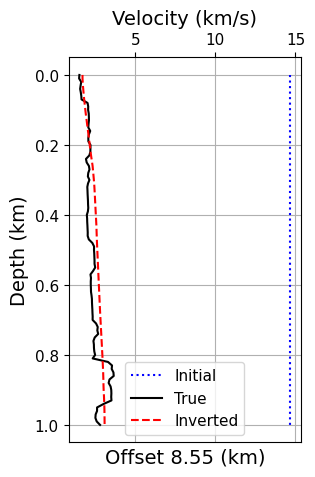

In [4]:
# Training
import time
start_time = time.time()
if args.field_synthetic=='y':
    loss_history = \
        training_loop(
            input_wonan, sx, np.ones_like(sx)*sz.reshape(-1,),
            tau_model, v_model, optimizer, args.num_epochs, 
            batch_size=Z.size//200, device=device, scheduler=scheduler,
            fast_loader=True, args=dict_args
    ) 
else:
    loss_history = \
        training_loop(
            input_wosrc, sx, np.ones_like(sx)*sz.reshape(-1,),
            tau_model, v_model, optimizer, args.num_epochs, 
            batch_size=Z.size//200, device=device, scheduler=scheduler, 
            fast_loader=True, args=dict_args
    )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

# Convergence history plot for verification
fig = plt.figure()
ax = plt.axes()
ax.semilogy(loss_history)
ax.set_xlabel('Epochs',fontsize=14)
plt.xticks(fontsize=11)
ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=11);
plt.grid()
plt.savefig(os.path.join(wandb_dir, "loss.png"), format='png', bbox_inches="tight")

# Prediction
input_wsrc = [i.ravel() for i in input_wsrc]
pde_loader, ic = create_dataloader(input_wsrc, sx, np.ones_like(sx)*sz.reshape(-1,), 
                                   shuffle=False, fast_loader=True)
v_pred = evaluate_velocity(v_model, pde_loader)

tau_pred = evaluate_tau(tau_model, pde_loader)
tau_pred = tau_pred.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x))

if args.factorization_type=='multiplicative':
    t_pred = (taud.reshape(nz,nx,len(id_sou_x)) + rec_op*tau_pred)*T0.reshape(nz,nx,len(id_sou_x))
else:
    t_pred = taud.reshape(nz,nx,len(id_sou_x)) + rec_op*tau_pred.reshape(nz,nx,len(id_sou_x)) + T0.reshape(nz,nx,len(id_sou_x))

v_pred = v_pred.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x))[:,:,0]
v_init = v_init.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x))[:,:,0]
v_true = velmodel.reshape(Z.shape)[::1,:,0]

if args.rescale_plot=='y':
    earth_radi = args.plotting_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax

    if args.depth_shift=='y':
        zmin, zmax, deltaz = earth_radi*(zmin-5), earth_radi*(zmax-5), earth_radi*deltaz
    else:
        zmin, zmax, deltaz = earth_radi*(zmin-0), earth_radi*(zmax-0), earth_radi*deltaz

    # Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)
    z = np.arange(zmin,zmax+deltaz,deltaz)
    x = np.arange(xmin,xmax+deltax,deltax)

    # Point-source locations
    sz = z[id_sou_z]
    sx = x[id_sou_x]

    Z,X,SX = np.meshgrid(z,x,sx,indexing='ij')

    SZ = np.ones(SX.shape)*sz # Creating an array of sources along z with same size as SX

    t_pred, T_data, T0 = t_pred*args.plotting_factor, T_data*args.plotting_factor, T0*args.plotting_factor

plot_section(v_pred, "v_pred.png", vmin=np.nanmin(velmodel)+0.1, vmax=np.nanmax(velmodel)-0.5, 
             save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
plot_section(velmodel.reshape(Z.shape)[:,:,0], 'v_true.png', 
             vmin=np.nanmin(velmodel)+0.1, vmax=np.nanmax(velmodel)-0.5, 
             save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 

for i in range(0, len(id_sou_x), plot_int):
    plot_section(tau_true[:,:,i], "tau_true_"+str(i)+".png", 's/km', 
                 vmin=tau_true.min(), vmax=tau_true.max(), 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
    plot_section(-tau_pred.reshape(Z.shape)[:,:,i], "tau_pred_"+str(i)+".png", 's/km', 
                 vmin=tau_true.min(), vmax=tau_true.max(), 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
    plot_contour(t_pred.reshape(nz,nx,len(id_sou_x)), T_true.reshape(nz,nx,len(id_sou_x)),
                 T0.reshape(nz,nx,len(id_sou_x)), i, nx, nz, len(id_sou_x), sx, sz, x, z,
                 'contour_'+str(i)+'.png', save_dir=wandb_dir)
    plot_section(t_pred.reshape(nz,nx,len(id_sou_x))[:,:,i], 't_pred_'+str(i)+'.png', 's', 
                 save_dir=wandb_dir, aspect='equal') 

v_pred[0,:] = np.copy(v_pred[1,:])

for i in range(0, len(x), len(x)//5):
    plot_trace(v_init, v_true, v_pred, i, x, z, "v_trace_"+str(i)+".png", save_dir=wandb_dir)

# Save model
torch.save({
        'tau_model_state_dict': tau_model.state_dict(),
        'v_model_state_dict': v_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_history
}, wandb_dir+'/saved_model')

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
v_model.load_state_dict(checkpoint['v_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])